In [1]:
import tensorflow as tf
#import wave
import glob
import scipy.io.wavfile as wavfile
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/tmulc/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [99]:
global SMP_RATE
SMP_RATE = 16000

In [2]:
def getWaveName(wavepath):
    return wavepath.split('/')[-1]

def findWave(wavefile,path):
    r = glob.glob(path+wavefile)
    return r[0]

In [7]:
fpath = '../data/female_us/'
mpath = '../data/male_us/'

In [102]:
#male
result = []
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    result.append(wav_data.shape[0]/(1.0*fm))
    assert fm == SMP_RATE
resultm = np.array(result)

#female
result = []
for filename in glob.glob(fpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    result.append(wav_data.shape[0]/(1.0*fm))
    assert fm == SMP_RATE
resultf = np.array(result)

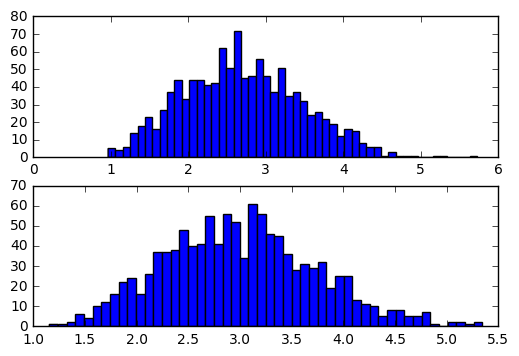

In [103]:
plt.subplot(211)
plt.hist(resultm,bins=50)
plt.subplot(212)
plt.hist(resultf,bins=50)
plt.show()

# Hacky parallel dataset

In [14]:
# map male to female
m2f = dict()
for i in glob.glob(mpath+'/*.wav'):
    m2f[i]=findWave(getWaveName(i),fpath)

In [18]:
m2f.keys()[0]

'../data/male_us/arctic_a0058.wav'

# Bin before hand

In [ ]:
bin_size_x = (2,3)
bin_size_y = (2,3)

In [67]:
bin_mapping = {}
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    size = wav_data.shape[0]/(1.0*fm)
    if size < bin_size_x[1] and size > bin_size_x[0]:
        fm2, wav_data2 = wavfile.read(m2f[filename])
        size2 = wav_data2.shape[0]/(1.0*fm2)
        if size2 < bin_size_x[1] and size2 > bin_size_x[0]:
            bin_mapping[filename] = m2f[filename]

In [69]:
len(bin_mapping)

348

# Sec to Samples

In [110]:
def sec2samp(sec,smp_rate):
    return int(sec*smp_rate)

# Padding

In [123]:
def padTo(x,size,kind='SYM'):
    """
    Expects 1D array
    """
    assert kind in ['LEFT','RIGHT','SYM']
    if kind == 'LEFT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((pad,x),axis=0)
    elif kind == 'RIGHT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((x,pad),axis=0)
    elif kind == 'SYM':
        padl = np.zeros((size-len(x))/2,dtype=x.dtype)
        padr = np.zeros((size-len(x))/2+(size-len(x))%2,dtype=x.dtype)
        r = np.concatenate((padl,x,padr),axis=0)
    return r

In [128]:
padTo(np.array([1,2,3]),6,kind='LEFT')

array([0, 0, 0, 1, 2, 3])

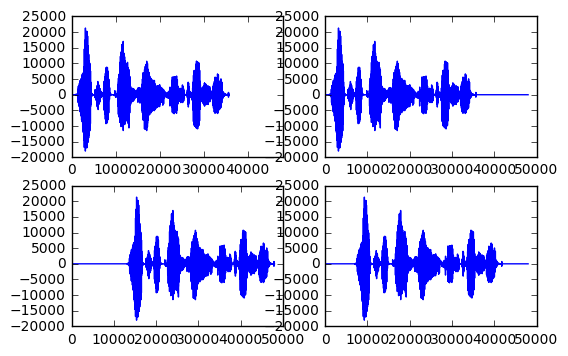

In [132]:
_,x = wavfile.read(bin_mapping.keys()[0])
plt.subplot(221)
plt.plot(x)
plt.xlim(0,SMP_RATE*bin_size_x[1])
plt.subplot(222)
plt.plot(padTo(x,SMP_RATE*bin_size_x[1],kind='RIGHT'))
plt.subplot(223)
plt.plot(padTo(x,SMP_RATE*bin_size_x[1],kind='LEFT'))
plt.subplot(224)
plt.plot(padTo(x,SMP_RATE*bin_size_x[1]))
plt.show()

# Batch Generator

In [142]:
class Batch(object):
    def __init__(self,mapping,bin_max,batch_size=1):
        self.mapping = mapping
        self.bin_max = bin_max
        self.seq_size = self.bin_max*SMP_RATE
        self.x_list = mapping.keys()
        self.size = len(self.x_list)
        self.batch_size = batch_size
        self.cursors = [(self.size//self.batch_size)*i for i in range(self.batch_size)]
        
    def getBatch(self):
        x_path = [self.x_list[c] for c in self.cursors]
        y_path = [self.mapping[xp] for xp in x_path]
        
        #xs
        x = np.empty(shape=(self.batch_size,self.seq_size))
        for i,xp in enumerate(x_path):
            _,x_raw=wavfile.read(xp)
            x_pad = padTo(x_raw,self.bin_max*SMP_RATE)
            x[i,:]=x_pad
        #x = 
        #_,x = wavfile.read(xp)
        #_,y = wavfile.read(y_path)
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return x
        return zip(x_path,y_path)
        
        

In [158]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=2)
b.getBatch()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

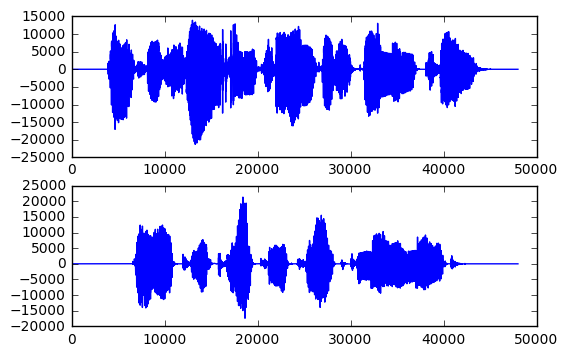

In [161]:
temp = b.getBatch()
plt.subplot(211)
plt.plot(temp[0])
plt.subplot(212)
plt.plot(temp[1])

# 1D Convolutions

In [60]:
b.getBatch()[0]

('../data/male_us/arctic_a0110.wav', '../data/female_us/arctic_a0110.wav')

In [51]:
b.cursors

[1]